# PESTPP-GLM

In this notebook, we will run PESTPP-GLM in standard parameter estimation mode and regularization mode.  In both cases, we will use the baked-in bayes-linear posterior monte carlo analysis to get posterior forecast PDFs.  We will use the prior monte carlo outputs as the prior forecast PDF.

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
import pyemu


flopy is installed in /Users/jeremyw/Dev/gw1876/activities_2day_mfm/notebooks/flopy


In [2]:
t_d = "template"
m_d = "master_glm"

In [3]:
pst = pyemu.Pst(os.path.join(t_d,"freyberg.pst"))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
grhk4,grhk4,log,705,0,1,-1,0.5
rech4_cn,rech4_cn,log,1,0,0.0791812,-0.09691,0.0440228
grss4,grss4,log,705,0,1,-1,0.5
strt6_cn,strt6_cn,log,1,0,0.0211893,-0.0222764,0.0108664
pp_sy2,pp_sy2,log,32,0,0.243038,-0.60206,0.211275
grsy3,grsy3,log,705,0,0.243038,-0.60206,0.211275
grvka4,grvka4,log,705,0,1,-1,0.5
ss7_cn,ss7_cn,log,1,0,1,-1,0.5
pp_strt2,pp_strt2,log,32,0,0.0211893,-0.0222764,0.0108664
pp_vka0,pp_vka0,log,32,0,1,-1,0.5


### reduce the number of adjustable parameters

This is the painful part: we cant use 10K+ pars because we cant wait around for that many runs and then the linear algebra of factoring a 10k+ by 10K+ matrix is also difficult.  So that means we need to fix a lot a parameters #frownyface

In [4]:
par = pst.parameter_data

In [5]:
# grid-scale pars
gr_pars = par.loc[par.pargp.apply(lambda x: "gr" in x),"parnme"]
par.loc[gr_pars,"partrans"] = "fixed"
pst.npar_adj

620

In [6]:
# these are the sfr conductance parameters - Ive left all 40 adjustable
# but if you uncomment this, it will tie them into 1 parameter effectively
# strk_pars = par.loc[par.pargp=="strk","parnme"]
# p1 = strk_pars.iloc[0]
# par.loc[strk_pars.iloc[1:],"partrans"] = "tied"
# par.loc[strk_pars.iloc[1:],"partied"] = p1
# pst.npar_adj

In [7]:
par.loc[par.pargp.apply(lambda x: "pp" in x),"pargp"].unique()

array(['pp_hk0', 'pp_hk1', 'pp_hk2', 'pp_rech0', 'pp_rech1', 'pp_ss0',
       'pp_ss1', 'pp_ss2', 'pp_strt0', 'pp_strt1', 'pp_strt2', 'pp_sy0',
       'pp_sy1', 'pp_sy2', 'pp_vka0', 'pp_vka1', 'pp_vka2'], dtype=object)

Fix the storage pilot points - we still have layer-scale storage pars adjustable

In [8]:
#s_pars = par.loc[par.pargp.apply(lambda x: "pp" in x and ("ss" in x or "sy" in x)),"parnme"]
#par.loc[s_pars,"partrans"] = "fixed"
pst.npar_adj

620

In [9]:
adj_par = par.loc[par.partrans=="log",:]
adj_par.pargp.value_counts().sort_values()

hk7_cn          1
vka6_cn         1
ss6_cn          1
ss7_cn          1
hk6_cn          1
rech4_cn        1
rech5_cn        1
vka8_cn         1
strt7_cn        1
ss8_cn          1
flow            1
strt8_cn        1
sy7_cn          1
vka7_cn         1
hk8_cn          1
sy8_cn          1
strt6_cn        1
sy6_cn          1
welflux         2
welflux_k02     6
drncond_k00    10
pp_hk0         32
pp_strt1       32
pp_sy2         32
pp_hk2         32
pp_ss1         32
pp_strt2       32
pp_hk1         32
pp_strt0       32
pp_vka1        32
pp_vka2        32
pp_vka0        32
pp_rech0       32
pp_rech1       32
pp_ss2         32
pp_ss0         32
pp_sy0         32
pp_sy1         32
strk           40
Name: pargp, dtype: int64

fix the future recharge pilot points, vka in layers 1 and 3 and the initial condition pilot points (we still have layer-scale pars for each of these types)

In [10]:
fi_grps = ["pp_rech1","pp_vka0","pp_vka2","pp_strt0","pp_strt1","pp_strt2"]
par.loc[par.pargp.apply(lambda x: x in fi_grps),"partrans"] = "fixed"
pst.npar_adj

428

Ok, thats better...so lets run PESTPP-GLM.  We will use a single "base parameter" jacobian matrix as the basis for 6 super parameter iterations.  Then we will draw 100 realizations from the FOSM posterior parameter covariance matrix and run those 100 realizations to get the psoterior forecast PDFs

In [11]:
pst.control_data.noptmax = 3
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 3
pst.pestpp_options["num_reals"] = 30 # this is how many ies uses
pst.pestpp_options["parcov"] = "prior_cov.jcb"
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

In [12]:
pyemu.os_utils.start_slaves(t_d,"pestpp-glm","freyberg_pp.pst",num_slaves=20,slave_root=".",
                           master_dir=m_d)

In [13]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

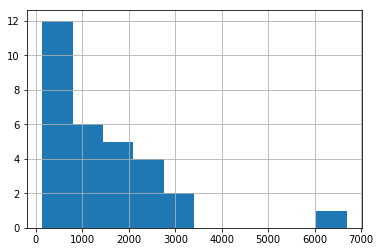

In [14]:
ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))

Here we see the distribution of phi values across the 100 posterior realizations.  Should we accept all of these???  The theoretical phi we should accept is number of nonzero obs (14).

To get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [15]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] #just take the 20 lowest phi realizations

We can also load and plot the FOSM forecast results along side of the ensemble results:

In [17]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_19791230,-977.2390,295.32800,-1567.8900,-386.5840,-1353.4000,247.839000,-1849.0800,-857.7250
fa_hw_19801229,-351.2160,409.77000,-1170.7600,468.3240,-399.0650,335.565000,-1070.2000,272.0660
fa_tw_19791230,-453.0330,409.35100,-1271.7400,365.6690,-712.0900,170.592000,-1053.2700,-370.9060
fa_tw_19801229,108.9600,506.73200,-904.5040,1122.4200,122.4170,263.672000,-404.9260,649.7600
hds_00_013_002_000,39.6102,3.96314,31.6840,47.5365,39.0899,0.273990,38.5420,39.6379
hds_00_013_002_001,38.3838,4.05782,30.2681,46.4994,37.5112,0.687837,36.1355,38.8868


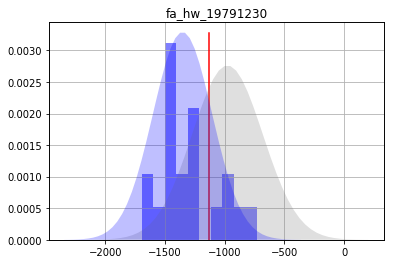

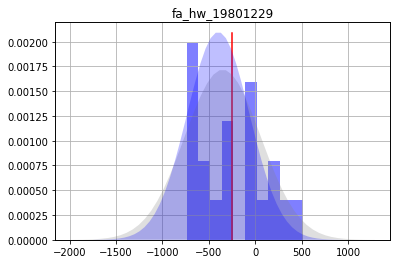

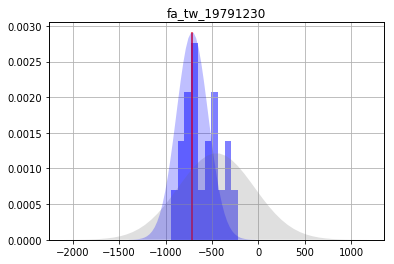

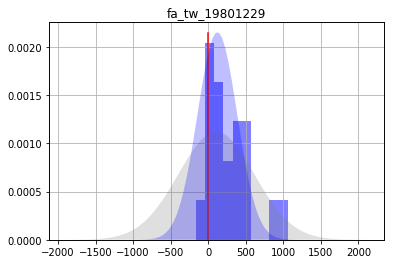

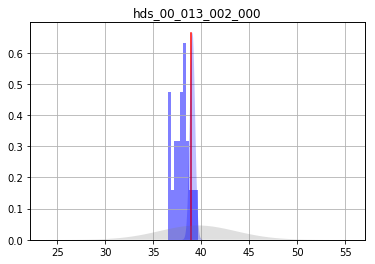

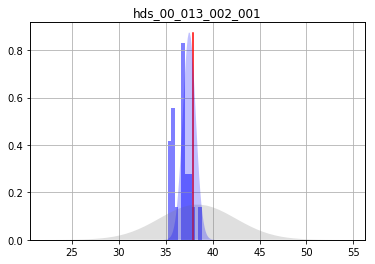

In [18]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,normed=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()

### Setup of Tikhonov regularization

Now lets setup and use some formal regularization to bring the final phi up to around 14.  We will use first-order regularization based on the covariance matrix we build earlier:

In [19]:
cov = pyemu.Cov.from_binary(os.path.join(t_d,"prior_cov.jcb"))

In [20]:
cnames = set(cov.row_names)
pnames = set(pst.adj_par_names)
cnames.symmetric_difference(pnames)

{'ss3024002',
 'sy3015015',
 'sy3006002',
 'vka4005004',
 'ss4016011',
 'strt3021007',
 'hk3025007',
 'strt5038014',
 'ss5036017',
 'sy5005001',
 'sy3028008',
 'sy3013001',
 'rech2028002',
 'ss3035012',
 'vka5029019',
 'rech3008007',
 'vka3012010',
 'hk4027011',
 'vka3003005',
 'vka5024013',
 'vka5000015',
 'ss4024018',
 'vka5021008',
 'hk5012010',
 'ss4009001',
 'sy3032008',
 'sy4008008',
 'ss5019016',
 'ss3020015',
 'hk3014010',
 'vka5026009',
 'hk5033014',
 'vka3006010',
 'sy5005018',
 'hk3039007',
 'strt5006015',
 'hk5010008',
 'strt4024002',
 'sy5012019',
 'strt4013003',
 'ss3016017',
 'sy4000008',
 'vka4032002',
 'ss3005002',
 'hk4028007',
 'vka3037011',
 'strt5013015',
 'strt4017012',
 'hk4033018',
 'hk5008010',
 'strt5021015',
 'sy5029001',
 'strt4001006',
 'vka5033002',
 'rech2001018',
 'sy3001007',
 'hk3023011',
 'rech3023018',
 'strt016',
 'hk5023008',
 'strt108',
 'vka3017018',
 'sy5003013',
 'sy5036012',
 'ss5038010',
 'strt3029003',
 'strt4029002',
 'hk5018003',
 'sy40290

In [21]:
pyemu.helpers.first_order_pearson_tikhonov(pst,cov)

getting CC matrix
processing


In [22]:
pst.prior_information.head()

,equation,obgnme,pilbl,weight
pilbl,,,,
pcc_1,1.0 * log(dc0000390005) - 1.0 * log(dc0000390006) = 0.0,regul_cc,pcc_1,0.904837
pcc_2,1.0 * log(dc0000390005) - 1.0 * log(dc0000390007) = 0.0,regul_cc,pcc_2,0.818731
pcc_3,1.0 * log(dc0000390005) - 1.0 * log(dc0000390008) = 0.0,regul_cc,pcc_3,0.740818
pcc_4,1.0 * log(dc0000390005) - 1.0 * log(dc0000390009) = 0.0,regul_cc,pcc_4,0.670320
pcc_5,1.0 * log(dc0000390005) - 1.0 * log(dc0000390010) = 0.0,regul_cc,pcc_5,0.606531


In [23]:
shutil.copy2(os.path.join(m_d,"freyberg_pp.jcb"),os.path.join(t_d,"restart_pp.jcb"))


'template/restart_pp.jcb'

In [24]:
pst.pestpp_options["base_jacobian"] = "restart_pp.jcb"
pst.reg_data.phimlim = pst.nnz_obs
pst.reg_data.phimaccept = pst.reg_data.phimlim * 1.1
pst.write(os.path.join(t_d,"freyberg_pp.pst"))

In [25]:
pyemu.os_utils.start_slaves(t_d,"pestpp-glm","freyberg_pp.pst",num_slaves=20,slave_root=".",
                           master_dir=m_d)

In [26]:
df = df=pd.read_csv(os.path.join(m_d,"freyberg_pp.post.obsen.csv"),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

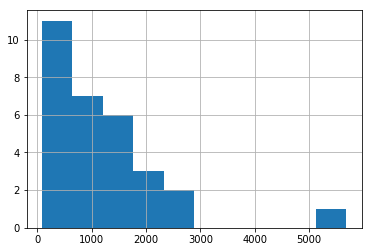

In [27]:
ax = oe.phi_vector.hist()#bins=np.linspace(0,100,20))

Same as before, to get a "posterior" ensemble, we need to throw out the realizations with large phi - lets just take the 20 best:

In [28]:
oe_pt = oe.loc[oe.phi_vector.sort_values().index[:20],:] 

In [29]:
f_df = pd.read_csv(os.path.join(m_d,"freyberg_pp.pred.usum.csv"),index_col=0)
f_df.index = f_df.index.map(str.lower)
f_df

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
fa_hw_19791230,-977.2390,295.32800,-1567.8900,-386.5840,-1354.3600,249.469000,-1853.2900,-855.4170
fa_hw_19801229,-351.2160,409.77000,-1170.7600,468.3240,-421.9530,338.242000,-1098.4400,254.5310
fa_tw_19791230,-453.0330,409.35100,-1271.7400,365.6690,-751.4970,175.174000,-1101.8400,-401.1500
fa_tw_19801229,108.9600,506.73200,-904.5040,1122.4200,72.8314,267.254000,-461.6770,607.3400
hds_00_013_002_000,39.6102,3.96314,31.6840,47.5365,39.1835,0.281947,38.6196,39.7474
hds_00_013_002_001,38.3838,4.05782,30.2681,46.4994,37.6265,0.691057,36.2444,39.0086


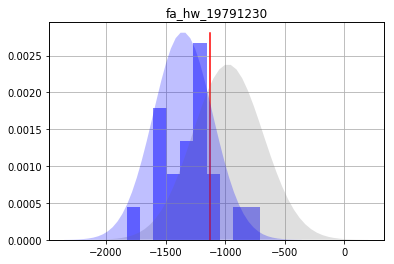

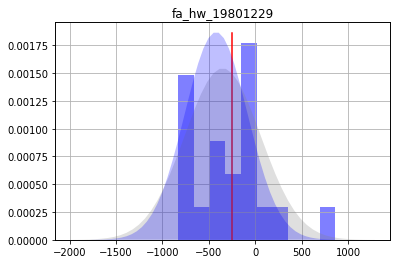

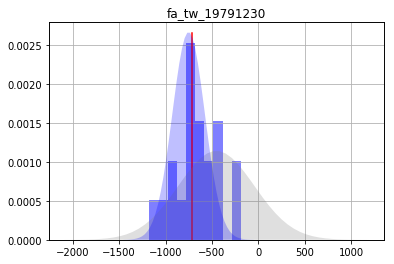

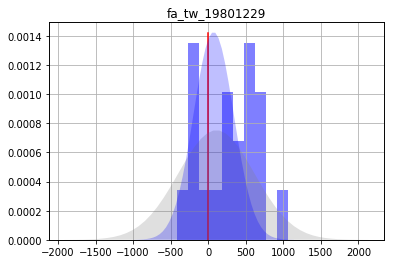

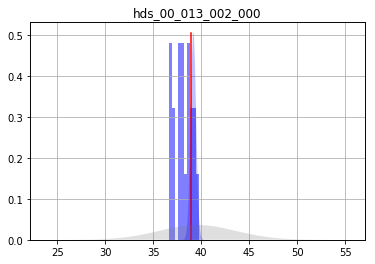

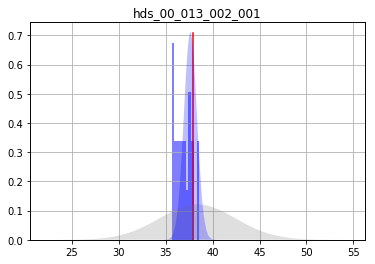

In [30]:
obs = pst.observation_data
fnames = pst.pestpp_options["forecasts"].split(",")
for forecast in fnames:
    ax = plt.subplot(111)
    oe_pt.loc[:,forecast].hist(ax=ax,color="b",alpha=0.5,normed=True)
    ax.plot([obs.loc[forecast,"obsval"],obs.loc[forecast,"obsval"]],ax.get_ylim(),"r")
    axt = plt.twinx()
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"prior_mean"],f_df.loc[forecast,"prior_stdev"])
    axt.fill_between(x,0,y,facecolor="0.5",alpha=0.25)
    x,y = pyemu.plot_utils.gaussian_distribution(f_df.loc[forecast,"post_mean"],f_df.loc[forecast,"post_stdev"])
    axt.fill_between(x,0,y,facecolor="b",alpha=0.25)
    axt.set_ylim(0,axt.get_ylim()[1])
    axt.set_yticks([])
    ax.set_title(forecast)
    plt.show()